In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier

In [3]:
titanic = pd.read_csv("/kaggle/input/titanic/train.csv")
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test = pd.read_csv("/kaggle/input/titanic/test.csv")
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
titanic.shape

(891, 12)

In [6]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [8]:
total_null = titanic.isnull().sum().sum()
total_cell = np.product(titanic.shape)
percent_null = (total_null/total_cell)*100
print(f'Total Percentage of Null Values in dataset is {percent_null}%')

Total Percentage of Null Values in dataset is 8.099513655069211%


In [9]:
titanic.dropna(subset=['Age','Embarked'],inplace=True)

**Survival Column(Target)**

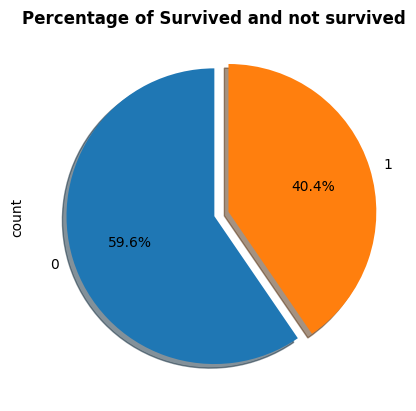

In [10]:
titanic['Survived'].value_counts().plot.pie(autopct='%0.1f%%',startangle=90,explode=[0,0.1],shadow=True)
plt.title('Percentage of Survived and not survived',fontweight='bold')
plt.show()

Nearly 60% of people died, and 40% of people survived.

**Sex Column**

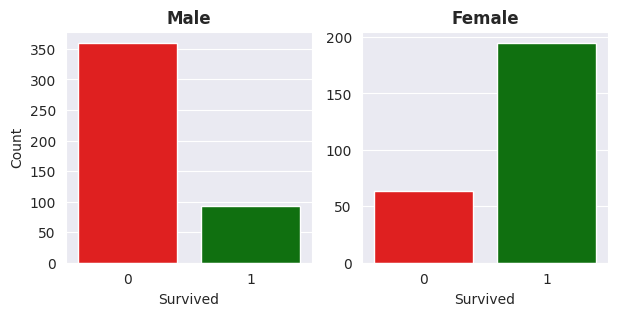

In [11]:
sns.set_style('darkgrid')
fig,ax = plt.subplots(figsize=(7,3),ncols=2)
Male_Survived = titanic[titanic['Sex'] == 'male']['Survived'].value_counts()
sns.barplot(x = Male_Survived.index,y= Male_Survived.values,palette=['Red','Green'],ax=ax[0])
ax[0].set_title('Male',fontweight='bold')
ax[0].set_ylabel('Count')
ax[0].set_xlabel('Survived')


Female_Survived = titanic[titanic['Sex'] == 'female']['Survived'].value_counts()
sns.barplot(x = Female_Survived.index,y= Female_Survived.values,palette=['Red','Green'],ax=ax[1])
ax[1].set_title('Female',fontweight='bold')
ax[1].set_xlabel('Survived')


plt.show()

A larger number of people were male.

**PClass Column**

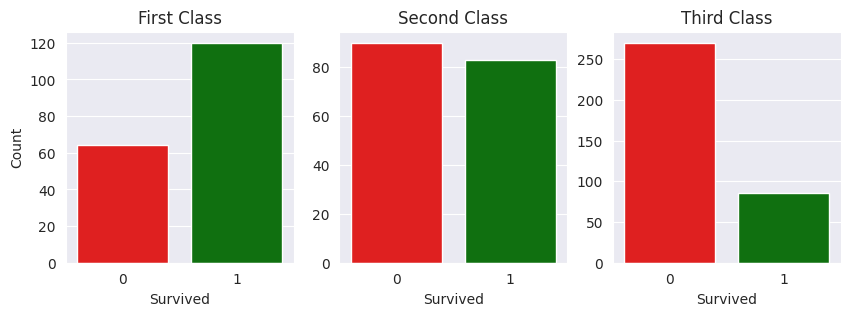

In [12]:
sns.set_style('darkgrid')
fig,ax = plt.subplots(figsize=(10,3),ncols=3)
First_Class = titanic[titanic['Pclass'] == 1]['Survived'].value_counts()
sns.barplot(x=First_Class.index,y=First_Class.values,palette=['Red','Green'],ax=ax[0])
ax[0].set_title('First Class')
ax[0].set_ylabel('Count')
ax[0].set_xlabel('Survived')

Second_Class = titanic[titanic['Pclass'] == 2]['Survived'].value_counts()
sns.barplot(x=Second_Class.index,y=Second_Class.values,palette=['Red','Green'],ax=ax[1])
ax[1].set_title('Second Class')
ax[1].set_xlabel('Survived')

Third_Class = titanic[titanic['Pclass'] == 3]['Survived'].value_counts()
sns.barplot(x=Third_Class.index,y=Third_Class.values,palette=['Red','Green'],ax=ax[2])
ax[2].set_title('Third Class')
ax[2].set_xlabel('Survived')

plt.show()

A larger number of people were in third class.

**Feature Creation**

**Age_Category Column**

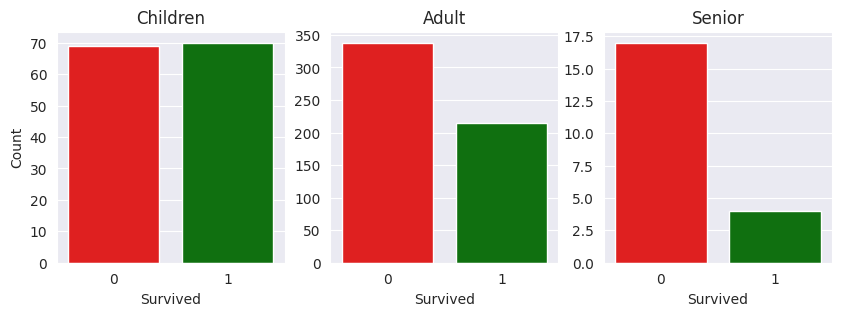

In [13]:
def categorize_age(age):
    if age <= 18:
        return 'Child'
    elif 18 < age <= 60:
        return 'Adult'
    else:
        return 'Senior'

titanic['Age_Category'] = titanic['Age'].apply(categorize_age)

fig,ax = plt.subplots(figsize=(10,3),ncols = 3)
Children = titanic[(titanic['Age_Category'] == 'Child')]['Survived'].value_counts()
sns.barplot(x=Children.index,y=Children.values,palette=['Red','Green'],ax=ax[0])
ax[0].set_title('Children')
ax[0].set_ylabel('Count')
ax[0].set_xlabel('Survived')


Adult = titanic[(titanic['Age_Category'] == 'Adult')]['Survived'].value_counts()
sns.barplot(x=Adult.index,y=Adult.values,palette=['Red','Green'],ax=ax[1])
ax[1].set_title('Adult')
ax[1].set_xlabel('Survived')

Senior = titanic[(titanic['Age_Category'] == 'Senior')]['Survived'].value_counts()
sns.barplot(x=Senior.index,y=Senior.values,palette=['Red','Green'],ax=ax[2])
ax[2].set_title('Senior')
ax[2].set_xlabel('Survived')

plt.show()

A larger number of people were adults on the Titanic.

**Embarked Column**

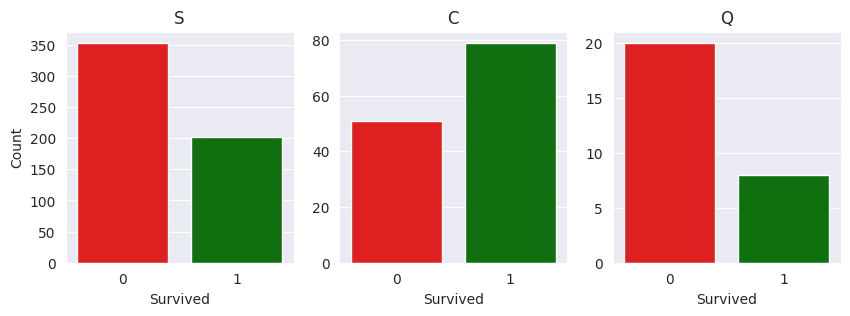

In [14]:
fig,ax = plt.subplots(figsize=(10,3),ncols = 3)
S = titanic[(titanic['Embarked'] == 'S')]['Survived'].value_counts()
sns.barplot(x=S.index,y=S.values,palette=['Red','Green'],ax=ax[0])
ax[0].set_title('S')
ax[0].set_ylabel('Count')
ax[0].set_xlabel('Survived')


C = titanic[(titanic['Embarked'] == 'C')]['Survived'].value_counts()
sns.barplot(x=C.index,y=C.values,palette=['Red','Green'],ax=ax[1])
ax[1].set_title('C')
ax[1].set_xlabel('Survived')

Q = titanic[(titanic['Embarked'] == 'Q')]['Survived'].value_counts()
sns.barplot(x=Q.index,y=Q.values,palette=['Red','Green'],ax=ax[2])
ax[2].set_title('Q')
ax[2].set_xlabel('Survived')

plt.show()

The majority of embarkation took place in Southampton (England).

**Feature Creation**

**Family_Size Column**

In [15]:
titanic['Name_Count'] = 1

family = ['Name_Count','SibSp','Parch']
titanic['Family_Size'] = titanic[family].sum(axis=1)

#For test data
test['Name_Count'] = 1
family = ['Name_Count','SibSp','Parch']
test['Family_Size'] = test[family].sum(axis=1)

titanic['Family_Size'].unique()

array([2, 1, 5, 3, 7, 6, 4, 8])

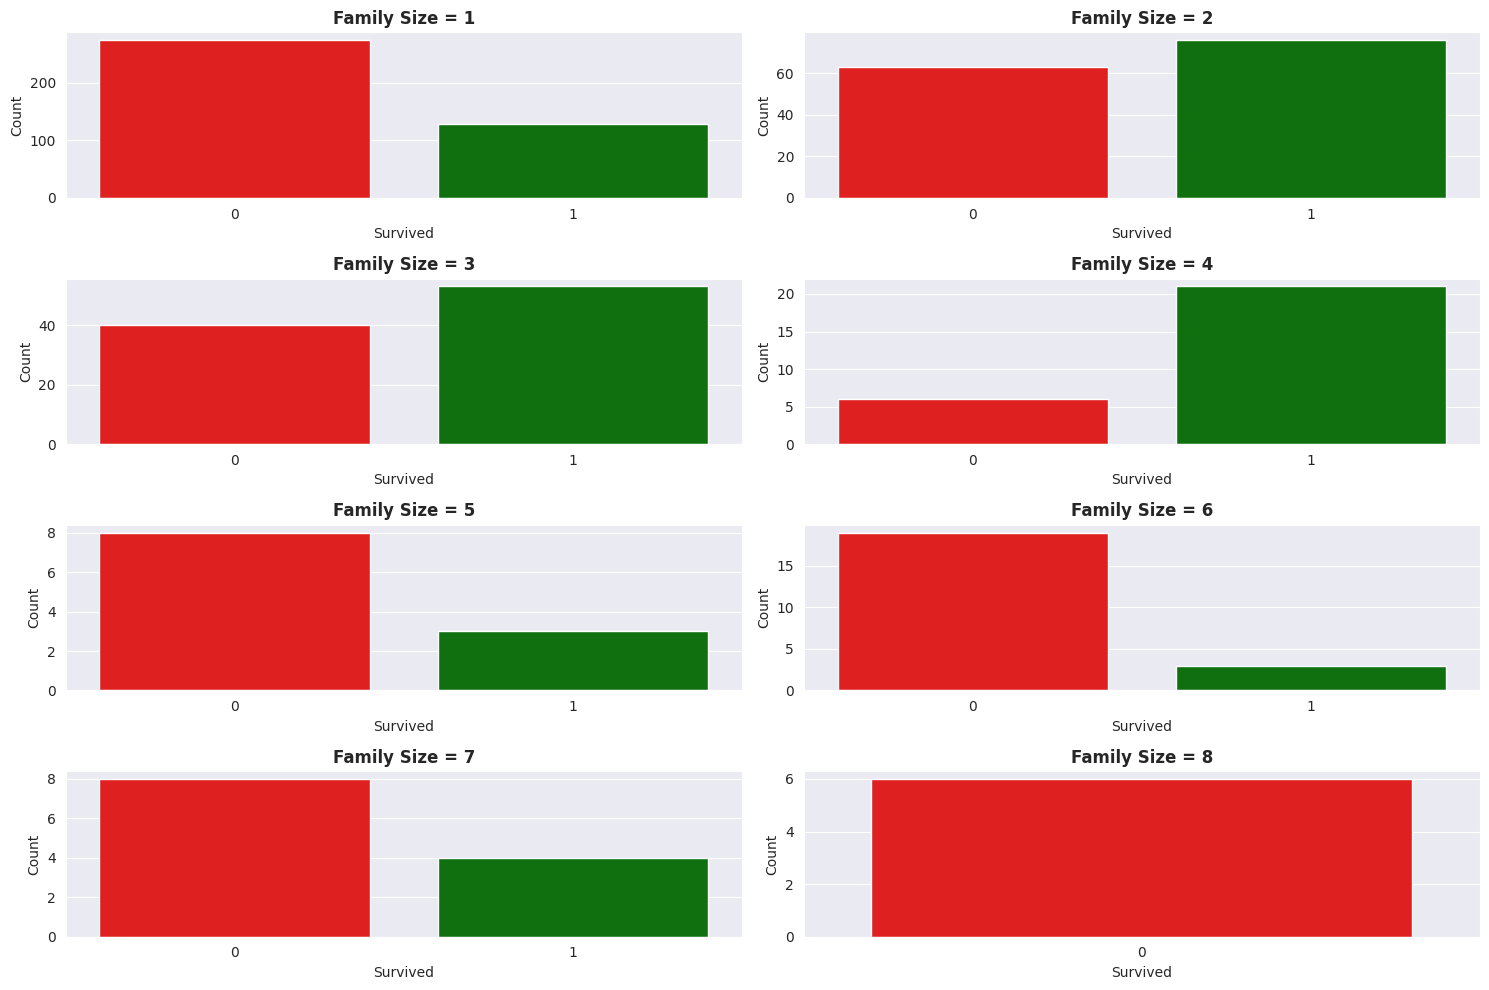

In [16]:
x = [1,2,3,4,5,6,7,8]
y = 1
plt.subplots(4,2,figsize=(15,10))
for i in x:
  plt.subplot(4,2,y)
  family = titanic[(titanic['Family_Size'] == i)]['Survived'].value_counts()
  sns.barplot(x=family.index,y=family.values,palette=['Red','Green'])
  plt.title(f'Family Size = {i}',fontweight='bold')
  plt.xlabel('Survived')
  plt.ylabel('Count')
  y += 1

plt.tight_layout()
plt.show()

**Making Predictions**

In [17]:
features = ['Pclass','Sex','Age','Family_Size']
X = pd.get_dummies(titanic[features])
X_test = pd.get_dummies(test[features])
y = titanic['Survived']

model = XGBClassifier(n_estimators=100, max_depth=5, random_state=1)

model.fit(X,y)
predictions = model.predict(X_test)

In [18]:
output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
